In [73]:
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

import cmbo
from IPython.display import display

from plot_stacked import *
from score_individual_objects import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
cfg = cmbo.utils.load_config("/Users/rstiskalek/Projects/CMBOlympics/scripts/config.toml")
data_MCXC = cmbo.io.load_mcxc_catalogue(cfg['paths']['MCXC_catalogue'])
data_eRASS = cmbo.io.load_erass_catalogue(cfg['paths']['eRASS_catalogue'])
data_tSZ = cmbo.io.read_Planck_cluster_catalog(cfg['paths']['Planck_tSZ_catalogue'])

Removing 94 MCXC entries with non-positive mass uncertainties.
Removing 1805 eRASS entries with M500 = -1.
Removing 1 eRASS entries with M500 > 3.00e+15 Msol.
Removing 559 Planck clusters with invalid redshifts (z <= 0 or NaN).


In [124]:
associations = cmbo.utils.load_associations("csiborg1", cfg)

Loaded 101 simulation realisations.
Identified 380 halo associations.
Halo signal datasets were not found in run_suite output.


In [129]:
match_kwargs = {
    "match_threshold": 0.05,
    "mass_preference_threshold": 0.01,
    "use_median_mass": True,
    "z_max": 0.045,
    "matching_method": "classical",
    "max_angular_sep": 120,
    "max_delta_cz": 1000,
}

catalogue_matched, assoc_matched, pvals, distances, nmatched, ntot = cmbo.match.match_planck_catalog_to_associations(
    data_tSZ, associations, **match_kwargs)

# catalogue_matched, assoc_matched, pvals, distances, nmatched, ntot = cmbo.match.match_mcxc_catalog_to_associations(
#   data_MCXC, associations, **match_kwargs)

# catalogue_matched, assoc_matched, pvals, distances, nmatched, ntot = cmbo.match.match_erass_catalog_to_associations(
    # data_eRASS, associations, **match_kwargs)


mu = assoc_matched.mean_log_mass
std = assoc_matched.std_log_mass

Classical matching: 24/36 clusters matched (66.7%)
2025-11-19 12:49:44 Matched 24/36 objects (66.7%)


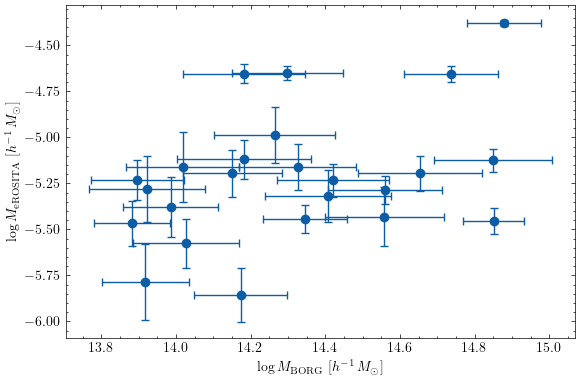

In [130]:
plt.figure(figsize=(6, 4))

x = np.array(mu)
xerr = std

# y = np.log10(catalogue_matched["M500"] * 0.68)
# yerr = catalogue_matched["eM500"] / (catalogue_matched["M500"] * np.log(10))

# y = np.log10(catalogue_matched["L500"] * 0.68)
# yerr = catalogue_matched["eL500"] / (catalogue_matched["L500"] * np.log(10))

y = np.log10(catalogue_matched["Y500_scaled"])
yerr = catalogue_matched["eY500_scaled"] / (catalogue_matched["Y500_scaled"] * np.log(10))


# y = np.log10(catalogue_matched['y5r500'])
# yerr = catalogue_matched['y5r500_err'] / (catalogue_matched['y5r500'] * np.log(10))

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3)

axmin, axmax = min(x.min(), y.min()), max(x.max(), y.max())
medx = np.median(x)
# plt.axline([medx, medx], slope=1, color='red', linestyle='--', label='1:1 line')

plt.xlabel(r'$\log M_{\rm BORG} ~ [h^{-1}\,M_\odot]$')
plt.ylabel(r'$\log M_{\rm eROSITA} ~ [h^{-1}\,M_\odot]$')
# plt.ylabel(r'$\log Y_{5R500} ~ [\mathrm{arcmin}^2]$')

plt.tight_layout()
# plt.savefig("/Users/rstiskalek/Downloads/mass_comparison_erass.png", dpi=450)
plt.show()

In [131]:
fitter = cmbo.utils.LinearRoxyFitter()
res = fitter.fit(x, y, xerr, yerr, method="mnr", x_pivot=14., y_pivot=-5.)
fitter.print_summary()


Optimisation Results:
slope:	0.5249927043914795
intercept:	-0.36244910955429077
sig:	0.3007122874259949
mu_gauss:	0.314538836479187
w_gauss:	0.29159119725227356

Running MCMC


sample: 100%|██████████| 5500/5500 [00:01<00:00, 3533.51it/s, 7 steps of size 4.00e-01. acc. prob=0.94] 



                 mean       std    median      2.5%     97.5%     n_eff     r_hat
  intercept     -0.37      0.12     -0.37     -0.60     -0.13   2320.10      1.00
   mu_gauss      0.31      0.07      0.31      0.17      0.46   3802.61      1.00
        sig      0.33      0.06      0.33      0.23      0.46   3450.00      1.00
      slope      0.53      0.28      0.53     -0.03      1.08   2266.16      1.00
    w_gauss      0.31      0.06      0.31      0.21      0.43   4551.93      1.00

Number of divergences: 0


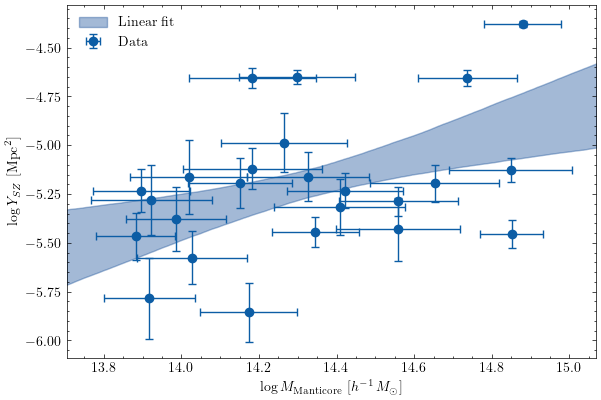

In [132]:
fig, ax = fitter.plot_fit(x, y, xerr, yerr, add_one_to_one=False)

ax.set_xlabel(r'$\log M_{\rm Manticore} ~ [h^{-1}\,M_\odot]$')
# ax.set_ylabel(r'$\log M_{\rm eROSITA} ~ [h^{-1}\,M_\odot]$')
ax.set_ylabel(r'$\log Y_{SZ} ~ [\mathrm{Mpc}^2]$')

fig.savefig("/Users/rstiskalek/Downloads/scatter.png", dpi=450, bbox_inches='tight')
display(fig)

In [133]:
cmbo.utils.correlation_with_errors(x, y, xerr, yerr, n_samples=10000, verbose=True)

100%|██████████| 10000/10000 [00:01<00:00, 5513.32it/s]


{'pearson': np.float64(0.3471923132078455),
 'pearson_err': np.float64(0.0931058982916687),
 'spearman': np.float64(0.2982608695652174),
 'spearman_err': np.float64(0.11732996786231081)}

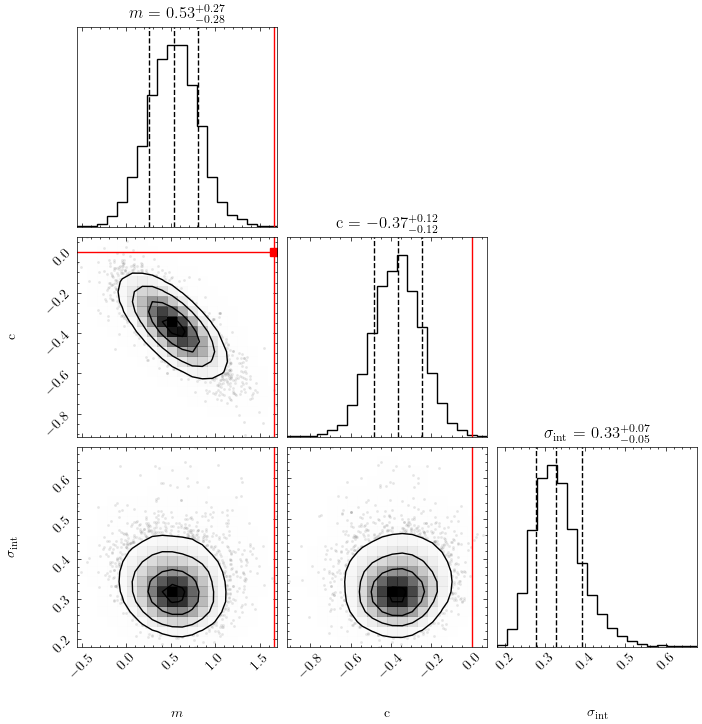

In [134]:
fig = fitter.plot_corner(truths=[5/3, 0, None])
fig.savefig("/Users/rstiskalek/Downloads/corner.png", dpi=450, bbox_inches='tight')

display(fig)

In [123]:
fitter.get_slope_intercept_significance([1, 0])

(np.float64(0.0), np.float64(inf))